## MobileNet V1 implementation using Pytorch

In [3]:
import torch
import torch.nn as nn

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# !pip install torchview
import torchvision
from torchview import draw_graph

In [17]:
class Depthwise_Seperable_Conv(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(Depthwise_Seperable_Conv, self).__init__()

    self.depthwise = nn.Conv2d(in_channels = in_channels,
                               out_channels = in_channels,
                               kernel_size = 3,
                               stride = stride,
                               padding = 1,
                               groups = in_channels,
                               bias=False)
    self.bn1 = nn.BatchNorm2d(in_channels)

    self.pointwise = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.depthwise(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.pointwise(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x

torch.Size([1, 64, 56, 56])


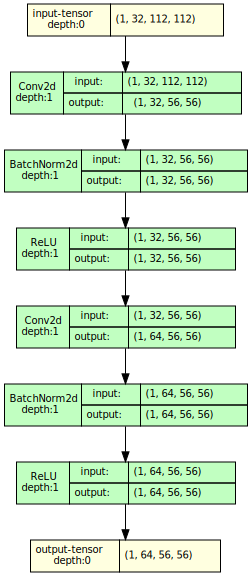

In [18]:
def test_DepthWiseSeperable():
    x = torch.randn(1,32,112,112)
    model = Depthwise_Seperable_Conv(32,64,2)
    print(model(x).shape)

    return model


model = test_DepthWiseSeperable()
architecture = 'DepthWiseSeperable'
model_graph = draw_graph(model, input_size=(1,32,112,112), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

In [29]:
class MobileNetV1(nn.Module):
  def __init__(self, num_classes=1000):
    super(MobileNetV1, self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=32,
                  kernel_size=3,
                  stride=2,
                  padding=1,
                  bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(32)
    )

    self.features = nn.Sequential(
        self.conv,
        Depthwise_Seperable_Conv(32, 64, 1),
        Depthwise_Seperable_Conv(64, 128, 2),
        Depthwise_Seperable_Conv(128, 128, 1),
        Depthwise_Seperable_Conv(128, 256, 2),
        Depthwise_Seperable_Conv(256, 256, 1),
        Depthwise_Seperable_Conv(256, 512, 2),

        Depthwise_Seperable_Conv(512, 512, 1),
        Depthwise_Seperable_Conv(512, 512, 1),
        Depthwise_Seperable_Conv(512, 512, 1),
        Depthwise_Seperable_Conv(512, 512, 1),
        Depthwise_Seperable_Conv(512, 512, 1),

        Depthwise_Seperable_Conv(512, 1024, 2),
        Depthwise_Seperable_Conv(1024, 1024, 1)
    )



    # Average pooling and classifier
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.classifier = nn.Sequential(
            nn.Linear(1024, num_classes),
        )


  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [30]:
# Create an instance of MobileNetV1
model = MobileNetV1()
print(model)

MobileNetV1(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Depthwise_Seperable_Conv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): Depthwise_Seperable_Conv(
      (depthwise): Conv2

In [34]:
def test_Mobilenet():
    x = torch.randn(1,3,224,224)
    model = MobileNetV1()
    print(model(x).shape)

    return model


model = test_Mobilenet()
architecture = 'mobilenetv1'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

torch.Size([1, 1000])


In [31]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
            Conv2d-2         [-1, 32, 112, 112]             864
              ReLU-3         [-1, 32, 112, 112]               0
              ReLU-4         [-1, 32, 112, 112]               0
       BatchNorm2d-5         [-1, 32, 112, 112]              64
       BatchNorm2d-6         [-1, 32, 112, 112]              64
            Conv2d-7         [-1, 32, 112, 112]             288
       BatchNorm2d-8         [-1, 32, 112, 112]              64
              ReLU-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           2,048
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
Depthwise_Seperable_Conv-13         [-1, 64, 112, 112]               0
           Conv2d-14           [

### References

- [MobilenetV1 pytorch implementationlink text](https://medium.com/@karuneshu21/implement-mobilenet-v1-in-pytorch-fd03a6618321)